# Modelos ARIMA



In [3]:
import os
# os.environ["SM_FRAMEWORK"] = "tf.keras"
import pathlib
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# import seaborn as sns
import datetime as dt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Flatten, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

In [4]:
#Conexi贸n de google drive con el repo
# from google.colab import drive
# drive.mount('/content/drive')

##==========================
# ruta = os.path.join("/content/drive/MyDrive","MonografiaUdeA")
# os.chdir(ruta)
abspath = pathlib.Path.cwd()
print(f"Directorio de trabajo: {abspath}")
###==========================

Directorio de trabajo: d:\OneDrive\OneDrive - INTERCONEXION ELECTRICA S.A. E.S.P\Posgrado\EspecializacionAnalitica\Sem_2\06_monografia\MonografiaUdeA


In [5]:
modelo_implementar = ['SARIMAX']

def parse(x):
    return dt.datetime.strptime(x, '%Y-%m-%d')
dataset = pd.read_csv(os.path.join(abspath,"datasets", "procesado", "3_dataset_filtrado.csv"), index_col=0, date_parser=parse)
df = dataset.copy()#.iloc[:,[0]].reset_index()
df = df[['precio_bolsa', 'precio_oferta']].reset_index()

In [6]:
df['fecha'] = pd.to_datetime(df['fecha'])
df.set_index('fecha', inplace=True)
df.head()

precio_bolsa  precio_oferta
fecha                                  
2010-01-01    120.501228     267.437633
2010-01-02    118.495340     277.153592
2010-01-03    121.160145     313.552755
2010-01-04    123.962937     303.519878
2010-01-05    120.666437     339.600449

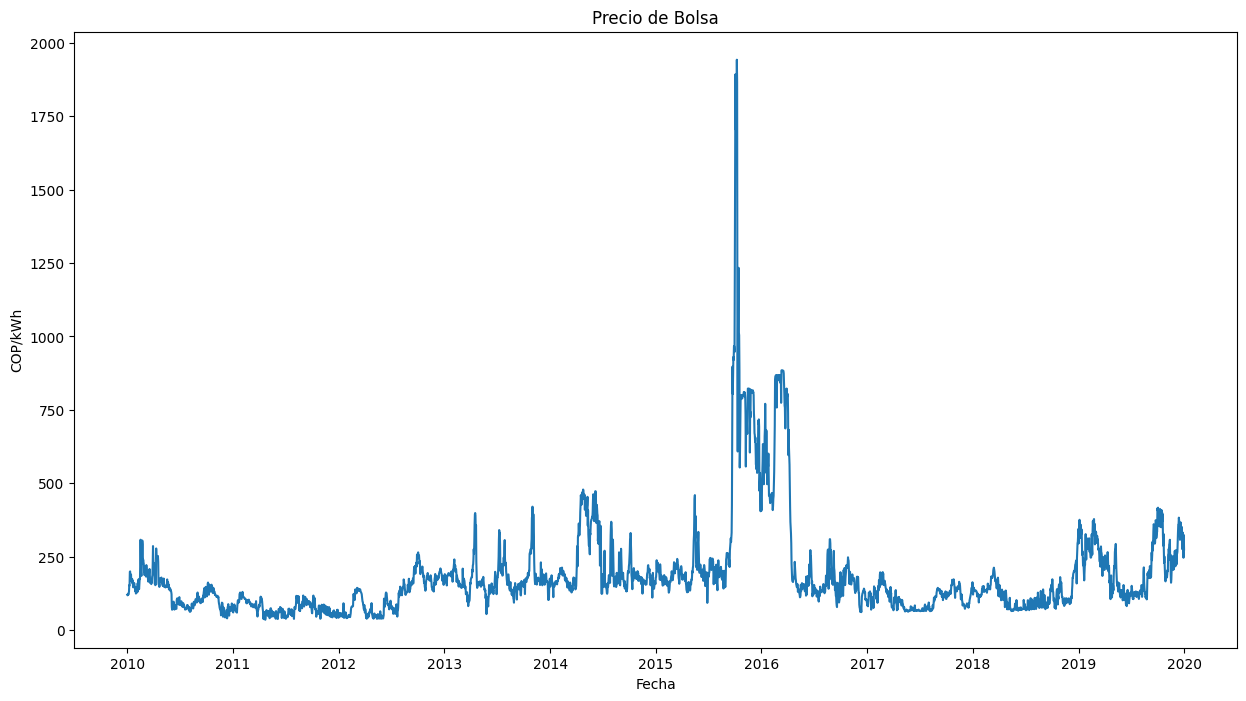

In [7]:
# Plot the time series
plt.figure(figsize = (15,8))
plt.plot(df['precio_bolsa'])
plt.title('Precio de Bolsa')
plt.xlabel('Fecha')
plt.ylabel('COP/kWh')
plt.show()

## Validaci贸n de estacionariedad

In [8]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['precio_bolsa'])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.436130
p-value: 0.000256


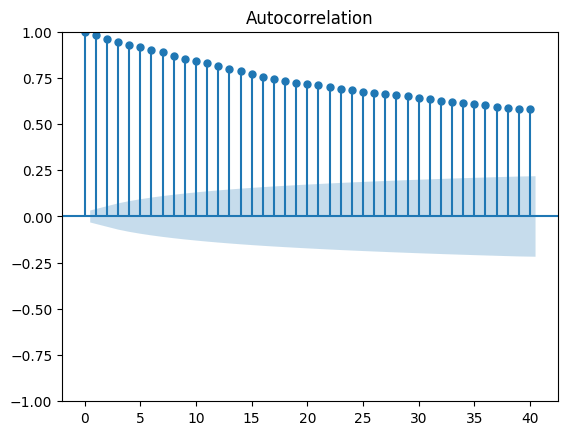

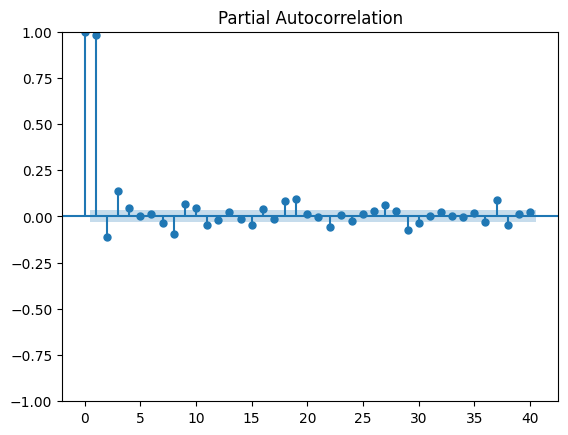

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['precio_bolsa'], lags=40)
plot_pacf(df['precio_bolsa'], lags=40)
plt.show()

Un valor p inferior a 0,05 indica estacionariedad y nuestros datos cumplen con este criterio, por lo que no es necesario realizar diferenciaci贸n.

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = ARIMA(df['precio_bolsa'], order=(1, 0, 1))
model_fit = model.fit()

c:\Anaconda3\envs\machine_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\envs\machine_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\envs\machine_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [11]:
forecast = model_fit.get_forecast(steps=30)

In [12]:
def arima_model(train, test, p = 1, d = 0, q = 1, exog = ''):
  pass

In [13]:
from sklearn.metrics import mean_squared_error

def sarimax_model (df, p, d , q , P , D , Q , s , train_porc = 0.8):
    train_size = int(len(df) * train_porc)
    train, test = df[0:train_size], df[train_size:len(df)]

    model_train = SARIMAX(train['precio_bolsa'], order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_train_fit = model_train.fit()

    test_forecast = model_train_fit.get_forecast(steps=len(test))
    test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

    mse = mean_squared_error(test['precio_bolsa'], test_forecast_series)
    mape = mean_absolute_percentage_error(test['precio_bolsa'], test_forecast_series)
    rmse = mse**0.5

    return (mape, mse, rmse)

    # plt.figure(figsize=(14,7))
    # plt.plot(train['precio_bolsa'], label='Training Data')
    # plt.plot(test['precio_bolsa'], label='Actual Data', color='orange')
    # plt.plot(test_forecast_series, label='Forecasted Data', color='green')
    # plt.fill_between(test.index,
    #                 test_forecast.conf_int().iloc[:, 0],
    #                 test_forecast.conf_int().iloc[:, 1],
    #                 color='k', alpha=.15)

    # plt.title('ARIMA Model Evaluation - Precio de Bolsa')
    # plt.xlabel('Fecha')
    # plt.ylabel('COP/kWh')
    # plt.legend()
    # plt.show()

    # print('RMSE:', rmse)

In [14]:
from itertools import product


p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)
P_values = range(0, 6)
D_values = range(0, 3)
Q_values = range(0, 6)
s_values = [30]
combinacion_parametros = list(product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

In [15]:
import warnings
warnings.filterwarnings("ignore")
def get_best_model(df, combinacion_parametros):
    best_score = float("inf")
    best_params = []
    for element in combinacion_parametros:
        print(element)
        p, d, q, P, D, Q, s = element
        mape, mse, rmse = sarimax_model(df,p = p, d = d, q = q, P = P, D = D, Q = Q, s=s)
        if mape < best_score:
            best_score, best_params = mape, element

    return mape, best_params

# mape, best_params = get_best_model(df, combinacion_parametros)

In [16]:
!pip install pmdarima -q
import pmdarima as pm

In [17]:
SARIMAX_model = pm.auto_arima(df[['precio_bolsa']],
                              exogenous=df[['precio_oferta']],
                              start_p=1, start_q=1,
                              test='adf',
                              max_p=6, max_q=6, m=12,
                              start_P=0, seasonal=True,
                              d=None, D=1,
                              trace=False,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True,
                              stationary = True)

In [19]:
import pickle
with open(os.path.join(abspath,"models", "iterations",modelo_implementar[0], "model.pkl"),'wb') as f:
    pickle.dump(SARIMAX_model,f)

In [20]:
with open(os.path.join(abspath,"models", "iterations",modelo_implementar[0], "model.pkl"),'rb') as f:
    mp = pickle.load(f)

In [21]:
mp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 3652
Model:             SARIMAX(4, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood              -17777.155
Date:                                 Tue, 18 Jun 2024   AIC                          35574.309
Time:                                         04:08:00   BIC                          35636.340
Sample:                                     01-01-2010   HQIC                         35596.399
                                          - 12-31-2019                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5472      0.598      2.589      0.010       0.376       2.719
ar.L1          1.1060      0.004    277.756      0.000       1.098       1.114
ar.L2         -0.2573      0.007    -36.351      0.000      -0.271      -0.243
ar.L3          0.0909      0.009      9.675      0.000       0.072       0.109
ar.L4          0.0469      0.007      6.563      0.000       0.033       0.061
ar.S.L12       0.9736      0.134      7.293      0.000       0.712       1.235
ar.S.L24      -0.5835      0.101     -5.790      0.000      -0.781      -0.386
ma.S.L12      -0.9896      0.137     -7.218      0.000      -1.258      -0.721
ma.S.L24       0.5465      0.109      4.995      0.000       0.332       0.761
sigma2       990.1567      4.656    212.675      0.000     981.032     999.282
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           4338360.66
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.82   Skew:                            -4.36
Prob(H) (two-sided):                  0.00   Kurtosis:                       171.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

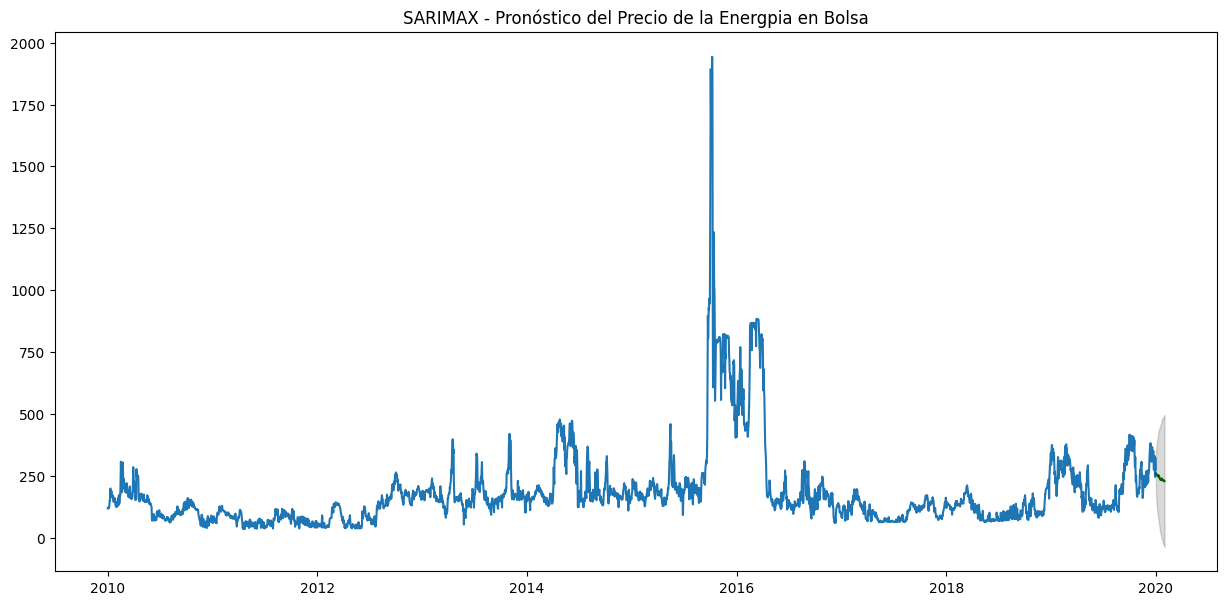

In [26]:
def sarimax_forecast(model, periods=30):
    n_periods = periods
    forecast_df = pd.DataFrame({"fecha": pd.date_range(df.index[-1], periods=n_periods, freq='D').day},
                               index=pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods=n_periods, freq='D'))

    fitted, confint = model.predict(n_periods=n_periods,
                                            return_conf_int=True,
                                            exogenous=forecast_df[['fecha']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods=n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(df["precio_bolsa"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15)

    plt.title("SARIMAX - Pron贸stico del Precio de la Energpia en Bolsa")
    plt.show()

    return fitted_series

fitted_series = sarimax_forecast(mp, periods=31)

In [27]:
# !pip install pydataxm
import pydataxm
from pydataxm.pydataxm import ReadDB
consult = ReadDB()

In [28]:
precio_bolsa = consult.request_data("PrecBolsNaci", "Sistema", dt.date(2020, 1, 1), dt.date(2020, 1, 31) )
hours = [f"Values_Hour{str(i).zfill(2)}" for i in range(1,25)]
precio_bolsa['precio_bolsa'] = precio_bolsa[hours].mean(axis=1)
precio_bolsa = precio_bolsa.groupby('Date')['precio_bolsa'].mean().reset_index()
precio_bolsa = precio_bolsa[ ['Date'] + ['precio_bolsa']]
precio_bolsa = precio_bolsa.rename(columns = {'Date': 'fecha'}).sort_values(by = 'fecha', ascending = True).reset_index(drop = True)
precio_bolsa['fecha'] = pd.to_datetime(precio_bolsa['fecha'])
precio_bolsa = precio_bolsa.set_index('fecha')
precio_bolsa.to_csv(os.path.join(abspath,"datasets", "procesado","precio_bolsa_ene_2020.csv"), index=True)

In [29]:
precio_bolsa_pronosticado = pd.DataFrame(fitted_series, columns = ['precio_bolsa_pronosticado'])
df_final = pd.merge(precio_bolsa,precio_bolsa_pronosticado, how = 'left', left_index = True, right_index=True)
df_final.tail()

precio_bolsa  precio_bolsa_pronosticado
fecha                                              
2020-01-27    376.813170                 230.789558
2020-01-28    363.087473                 229.383651
2020-01-29    373.977867                 231.420974
2020-01-30    371.410720                 231.915834
2020-01-31    375.983097                 230.314865

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

element_to_predict = 31
mse = mean_squared_error(df_final["precio_bolsa"][-int(element_to_predict):], df_final["precio_bolsa_pronosticado"][-int(element_to_predict):])
mae = mean_absolute_error(df_final["precio_bolsa"][-int(element_to_predict):], df_final["precio_bolsa_pronosticado"][-int(element_to_predict):])
rmse = mean_squared_error(df_final["precio_bolsa"][-int(element_to_predict):], df_final["precio_bolsa_pronosticado"][-int(element_to_predict):], squared=False)
mape = mean_absolute_percentage_error(df_final["precio_bolsa"][-int(element_to_predict):], df_final["precio_bolsa_pronosticado"][-int(element_to_predict):])
print("mse", mse.round(3))
print("mae", mae.round(3))
print("rmse", rmse.round(3))
print("mape", mape.round(3))

mse 12372.675
mae 97.998
rmse 111.233
mape 29.577
